In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
from matplotlib import gridspec

import uproot3 as uproot

# Plots setting
plt.rcParams['axes.labelsize'] = 13
tick_size = 13
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.title_fontsize'] = 13
legend_size = 12

In [2]:
from scipy.stats import norm, chisquare 
from scipy.optimize import curve_fit, leastsq
from scipy.special import logit

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost as xgb
from xgboost import XGBClassifier

### Import functions.py

In [3]:
# FUNCTIONS FOR EVENT SELECTION
# ----------------------------------------------------------------- EVENT SELECTION
def is_truth_nueCC(df):
    df_ = df[((abs(df.truth_nuPdg) == 12) & (df.truth_isCC == 1))]
    return df_

def is_truth_nueCC_inside(df):
    df_ = df[((abs(df.truth_nuPdg) == 12) & (df.truth_isCC == 1) & (df.truth_vtxInside == 1))]
    return df_

def is_truth_nueCC_outside(df):
    df_ = df[((abs(df.truth_nuPdg) == 12) & (df.truth_isCC == 1) & (df.truth_vtxInside == 0))]
    return df_

def is_truth_numuCC(df):
    df_ = df[((abs(df.truth_nuPdg) == 14) & (df.truth_isCC == 1))]
    return df_

def is_truth_numuCC_inside(df):
    df_ = df[((abs(df.truth_nuPdg) == 14) & (df.truth_isCC == 1) & (df.truth_vtxInside == 1))]
    return df_

def is_truth_numuCC_outside(df):
    df_ = df[((abs(df.truth_nuPdg) == 14) & (df.truth_isCC == 1) & (df.truth_vtxInside == 0))]
    return df_

def is_truth_NC(df):
    df_ = df[(df.truth_isCC == 0)]
    return df_

def is_truth_NC_inside(df):
    df_ = df[((df.truth_isCC == 0) & (df.truth_vtxInside == 1))]
    return df_

def is_truth_NC_outside(df):
    df_ = df[((df.truth_isCC == 0) & (df.truth_vtxInside == 0))]
    return df_

def is_FC(df):
    df_ = df[df.match_isFC == 1]
    return df_

def is_PC(df):
    df_ = df[df.match_isFC == 0]
    return df_

em_charge_scale = 0.95

def is_pi0(df, family='MC'):
    if family == 'DATA': df.loc[:,'kine_pio_mass'] = df.kine_pio_mass * em_charge_scale
    elif family == 'MC': pass
    else: print(' -------- WARNING: Wrong family')
        
    df_ = df[((df.kine_pio_flag == 1) & (df.kine_pio_vtx_dis < 9) | (df.kine_pio_flag == 2)) &
             (df.kine_pio_energy_1 > 40) & 
             (df.kine_pio_energy_2 > 25) & 
             (df.kine_pio_dis_1 < 110) & 
             (df.kine_pio_dis_2 < 120) & 
             (df.kine_pio_angle > 0) & 
             (df.kine_pio_angle < 174) & 
             (df.kine_pio_mass > 22) & 
             (df.kine_pio_mass < 300)]
    return df_

def is_NC(df):
    df_ = df[((df.cosmict_flag == 0) & (df.numu_score < 0))]
    return df_

def is_numuCC(df):
    df_ = df[((df.numu_cc_flag >= 0) & (df.numu_score > 0.9))]
    return df_

def is_nueCC(df):
    df_ = df[((df.numu_cc_flag >= 0) & (df.nue_score > 7))]
    return df_

def is_generic(df):
    df_ = is_preselection(df)
    df_ = df_[df_.stm_clusterlength > 15]
    return df_

def is_preselection(df):
    df_ = df[(df.match_found == 1) & 
             (df.stm_eventtype != 0) &
             (df.stm_lowenergy == 0) &
             (df.stm_LM == 0) &
             (df.stm_TGM == 0) &
             (df.stm_STM == 0) &
             (df.stm_FullDead == 0) &
             (df.stm_clusterlength > 0)]
    return df_

def Cosmic(df):
    # Badreco match or events with no true energy inside
    df_ = df[((df.match_completeness_energy <= df.truth_energyInside * 0.1) | (df.truth_energyInside <= 0))]
    return df_

def not_Cosmic(df):
    # Opposite of Cosmic
    df_ = df[~((df.match_completeness_energy <= df.truth_energyInside * 0.1) | (df.truth_energyInside <= 0))]
    return df_

def Active(df):
    # Active volume (truth)
    df_ = df[(df.truth_vtxX > -1) &
             (df.truth_vtxX <= 254.3) &
             (df.truth_vtxY > -115.0) &
             (df.truth_vtxY <= 117.0) &
             (df.truth_vtxZ > 0.6) &
             (df.truth_vtxZ <= 1036.4)]
    return df_


# FUNCTIONS FOR EVENT PRE-PROCESSING
# --------------------------------------------------------------------------------------- PRE-PROCESSING
def gen_run_subrun_list(input_file, name_list):
    # Get useful variables
    T_eval = uproot.open(input_file)['wcpselection/T_eval']
    df_eval = T_eval.pandas.df(['run', 'subrun'], flatten=False)
    df_eval.drop_duplicates(inplace=True) 
    np.savetxt(name_list, df_eval.values, fmt='%d')

BDT_variab_all = ['cosmic_n_solid_tracks', 'cosmic_energy_main_showers',
                  'cosmic_energy_direct_showers', 'cosmic_energy_indirect_showers',
                  'cosmic_n_direct_showers', 'cosmic_n_indirect_showers',
                  'cosmic_n_main_showers', 
                  # -----------------------------------------------
                  'gap_flag_prolong_u', 'gap_flag_prolong_v',
                  'gap_flag_prolong_w', 'gap_flag_parallel',
                  'gap_n_points', 'gap_n_bad',
                  'gap_energy', 'gap_num_valid_tracks',
                  'gap_flag_single_shower', 
                  # -----------------------------------------------
                  'mip_quality_energy', 'mip_quality_overlap',
                  'mip_quality_n_showers', 'mip_quality_n_tracks', 
                  'mip_quality_flag_inside_pi0', 'mip_quality_n_pi0_showers', 
                  'mip_quality_shortest_length', 'mip_quality_acc_length',
                  'mip_quality_shortest_angle', 'mip_quality_flag_proton',
                  # -----------------------------------------------
                  'mip_energy',
                  'mip_n_end_reduction', 'mip_n_first_mip',
                  'mip_n_first_non_mip', 'mip_n_first_non_mip_1',
                  'mip_n_first_non_mip_2', 'mip_vec_dQ_dx_0',
                  'mip_vec_dQ_dx_1', 'mip_vec_dQ_dx_2',
                  'mip_vec_dQ_dx_3', 'mip_vec_dQ_dx_4',
                  'mip_vec_dQ_dx_5', 'mip_vec_dQ_dx_6',
                  'mip_vec_dQ_dx_7', 'mip_vec_dQ_dx_8',
                  'mip_vec_dQ_dx_9', 'mip_vec_dQ_dx_10',
                  'mip_vec_dQ_dx_11', 'mip_vec_dQ_dx_12',
                  'mip_vec_dQ_dx_13', 'mip_vec_dQ_dx_14',
                  'mip_vec_dQ_dx_15', 'mip_vec_dQ_dx_16',
                  'mip_vec_dQ_dx_17', 'mip_vec_dQ_dx_18',
                  'mip_vec_dQ_dx_19', 'mip_max_dQ_dx_sample',
                  'mip_n_below_threshold', 'mip_n_below_zero',
                  'mip_n_lowest', 'mip_n_highest',
                  'mip_lowest_dQ_dx', 'mip_highest_dQ_dx',
                  'mip_medium_dQ_dx', 'mip_stem_length',
                  'mip_length_main', 'mip_length_total',
                  'mip_angle_beam', 'mip_iso_angle',
                  'mip_n_vertex', 'mip_n_good_tracks',
                  'mip_E_indirect_max_energy', 'mip_flag_all_above',
                  'mip_min_dQ_dx_5', 'mip_n_other_vertex',
                  'mip_n_stem_size', 'mip_flag_stem_trajectory',
                  'mip_min_dis', 
                  # -----------------------------------------------
                  'pio_mip_id', 'pio_flag_pio', 
                  # -----------------------------------------------
                  'pio_1_mass', 'pio_1_pio_type', 
                  'pio_1_energy_1', 'pio_1_energy_2', 
                  'pio_1_dis_1', 'pio_1_dis_2', 
                  # -----------------------------------------------
                  'mgo_energy',
                  'mgo_max_energy', 'mgo_total_energy',
                  'mgo_n_showers', 'mgo_max_energy_1',
                  'mgo_max_energy_2', 'mgo_total_other_energy',
                  'mgo_n_total_showers', 'mgo_total_other_energy_1',
                  # -----------------------------------------------
                  'mgt_flag_single_shower', 'mgt_max_energy',
                  'mgt_energy', 'mgt_total_other_energy',
                  'mgt_max_energy_1', 'mgt_e_indirect_max_energy',
                  'mgt_e_direct_max_energy', 'mgt_n_direct_showers',
                  'mgt_e_direct_total_energy', 'mgt_flag_indirect_max_pio',
                  'mgt_e_indirect_total_energy',
                  # -----------------------------------------------
                  'stw_1_energy', 'stw_1_dis',
                  'stw_1_dQ_dx', 'stw_1_flag_single_shower',
                  'stw_1_n_pi0', 'stw_1_num_valid_tracks',
                  # -----------------------------------------------
                  'spt_flag_single_shower', 'spt_energy',
                  'spt_shower_main_length', 'spt_shower_total_length',
                  'spt_angle_beam', 'spt_angle_vertical',
                  'spt_max_dQ_dx', 'spt_angle_beam_1',
                  'spt_angle_drift', 'spt_angle_drift_1',
                  'spt_num_valid_tracks', 'spt_n_vtx_segs',
                  'spt_max_length', 
                  # -----------------------------------------------
                  'stem_len_energy', 'stem_len_length',
                  'stem_len_flag_avoid_muon_check',
                  'stem_len_num_daughters', 'stem_len_daughter_length',
                  # -----------------------------------------------
                  'lem_shower_total_length',
                  'lem_shower_main_length', 'lem_n_3seg',
                  'lem_e_charge', 'lem_e_dQdx',
                  'lem_shower_num_segs', 'lem_shower_num_main_segs',
                  # -----------------------------------------------
                  'brm_n_mu_segs', 'brm_Ep',
                  'brm_energy', 'brm_acc_length',
                  'brm_shower_total_length', 'brm_connected_length',
                  'brm_n_size', 'brm_acc_direct_length',
                  'brm_n_shower_main_segs', 'brm_n_mu_main',
                  # -----------------------------------------------
                  'cme_mu_energy', 'cme_energy',
                  'cme_mu_length', 'cme_length',
                  'cme_angle_beam',
                  # -----------------------------------------------
                  'anc_energy', 'anc_angle',
                  'anc_max_angle', 'anc_max_length',
                  'anc_acc_forward_length', 'anc_acc_backward_length',
                  'anc_acc_forward_length1', 'anc_shower_main_length',
                  'anc_shower_total_length', 'anc_flag_main_outside',
                  # -----------------------------------------------
                  'stem_dir_flag_single_shower', 'stem_dir_angle',
                  'stem_dir_energy', 'stem_dir_angle1',
                  'stem_dir_angle2', 'stem_dir_angle3',
                  'stem_dir_ratio',
                  # -----------------------------------------------
                  'vis_1_n_vtx_segs', 'vis_1_energy',
                  'vis_1_num_good_tracks', 'vis_1_max_angle',
                  'vis_1_max_shower_angle', 'vis_1_tmp_length1',
                  'vis_1_tmp_length2', 'vis_1_particle_type',                                      
                  # -----------------------------------------------
                  'vis_2_n_vtx_segs', 'vis_2_min_angle',
                  'vis_2_min_weak_track', 'vis_2_angle_beam',
                  'vis_2_min_angle1', 'vis_2_iso_angle1',
                  'vis_2_min_medium_dQ_dx', 'vis_2_min_length',
                  'vis_2_sg_length', 'vis_2_max_angle',
                  'vis_2_max_weak_track',
                  # -----------------------------------------------
                  'br1_1_shower_type',
                  'br1_1_vtx_n_segs', 'br1_1_energy',
                  'br1_1_n_segs', 'br1_1_flag_sg_topology',
                  'br1_1_flag_sg_trajectory', 'br1_1_sg_length',
                  # -----------------------------------------------
                  'br1_2_energy', 'br1_2_n_connected',
                  'br1_2_max_length', 'br1_2_n_connected_1',
                  'br1_2_vtx_n_segs', 'br1_2_n_shower_segs',
                  'br1_2_max_length_ratio', 'br1_2_shower_length',
                  # -----------------------------------------------
                  'br1_3_energy', 'br1_3_n_connected_p',
                  'br1_3_max_length_p', 'br1_3_n_shower_segs',
                  'br1_3_flag_sg_topology', 'br1_3_flag_sg_trajectory',
                  'br1_3_n_shower_main_segs', 'br1_3_sg_length',
                  # -----------------------------------------------
                  'br2_flag_single_shower', 'br2_num_valid_tracks',
                  'br2_energy', 'br2_angle1',
                  'br2_angle2', 'br2_angle',
                  'br2_angle3', 'br2_n_shower_main_segs',
                  'br2_max_angle', 'br2_sg_length',
                  'br2_flag_sg_trajectory',                                     
                  # -----------------------------------------------
                  'br3_1_n_shower_segments', 'br3_1_sg_flag_trajectory',
                  'br3_1_sg_direct_length', 'br3_1_sg_length',
                  'br3_1_total_main_length', 'br3_1_total_length',
                  'br3_1_iso_angle', 'br3_1_sg_flag_topology',
                  # -----------------------------------------------
                  'br3_2_n_ele', 'br3_2_n_other',
                  'br3_2_energy', 'br3_2_total_main_length',
                  'br3_2_total_length', 'br3_2_other_fid',
                  # -----------------------------------------------
                  'br3_4_acc_length', 'br3_4_total_length',
                  'br3_4_energy', 
                  # -----------------------------------------------
                  'br3_7_energy', 'br3_7_min_angle', 
                  'br3_7_sg_length', 'br3_7_main_length', 
                  # -----------------------------------------------
                  'br3_8_max_dQ_dx', 'br3_8_energy', 'br3_8_n_main_segs',
                  'br3_8_shower_main_length', 'br3_8_shower_length',
                  # -----------------------------------------------
                  'br4_1_shower_main_length', 'br4_1_shower_total_length',
                  'br4_1_min_dis', 'br4_1_energy',
                  'br4_1_n_vtx_segs', 'br4_1_n_main_segs',
                  # -----------------------------------------------
                  'br4_2_ratio_45', 'br4_2_ratio_35',
                  'br4_2_ratio_25', 'br4_2_ratio_15',
                  'br4_2_energy', 'br4_2_ratio1_45',
                  'br4_2_ratio1_35', 'br4_2_ratio1_25',
                  'br4_2_ratio1_15', 'br4_2_iso_angle',
                  'br4_2_iso_angle1', 'br4_2_angle',                                     
                  # -----------------------------------------------
                  'tro_3_stem_length', 'tro_3_n_muon_segs',
                  'tro_3_energy',
                  # -----------------------------------------------
                  'hol_1_n_valid_tracks', 'hol_1_min_angle',
                  'hol_1_energy', 'hol_1_flag_all_shower',
                  'hol_1_min_length', 
                  # -----------------------------------------------
                  'hol_2_min_angle', 'hol_2_medium_dQ_dx',
                  'hol_2_ncount', 'hol_2_energy',
                  # -----------------------------------------------
                  'lol_3_angle_beam', 'lol_3_n_valid_tracks', 
                  'lol_3_min_angle', 'lol_3_vtx_n_segs', 
                  'lol_3_energy', 'lol_3_shower_main_length', 
                  'lol_3_n_out', 'lol_3_n_sum',
                  # -----------------------------------------------
                  'cosmict_2_particle_type', 'cosmict_2_n_muon_tracks',
                  'cosmict_2_flag_inside', 'cosmict_2_angle_beam',
                  'cosmict_2_flag_dir_weak', 'cosmict_2_dQ_dx_end',
                  'cosmict_2_dQ_dx_front', 'cosmict_2_theta',
                  'cosmict_2_phi', 'cosmict_2_valid_tracks',
                  # -----------------------------------------------
                  'cosmict_3_flag_inside',
                  'cosmict_3_angle_beam', 'cosmict_3_flag_dir_weak',
                  'cosmict_3_dQ_dx_end', 'cosmict_3_dQ_dx_front',
                  'cosmict_3_theta', 'cosmict_3_phi',
                  'cosmict_3_valid_tracks', 
                  # -----------------------------------------------
                  'cosmict_4_flag_inside', 'cosmict_4_angle_beam',
                  # -----------------------------------------------
                  'cosmict_5_flag_inside', 'cosmict_5_angle_beam', 
                  # -----------------------------------------------
                  'cosmict_6_flag_dir_weak', 'cosmict_6_flag_inside',
                  'cosmict_6_angle', 
                  # -----------------------------------------------
                  'cosmict_7_flag_sec', 'cosmict_7_n_muon_tracks',
                  'cosmict_7_flag_inside', 'cosmict_7_angle_beam',
                  'cosmict_7_flag_dir_weak', 'cosmict_7_dQ_dx_end',
                  'cosmict_7_dQ_dx_front', 'cosmict_7_theta',
                  'cosmict_7_phi', 
                  # -----------------------------------------------
                  'cosmict_8_flag_out', 'cosmict_8_muon_length',
                  'cosmict_8_acc_length',
                  # -----------------------------------------------
                  'numu_cc_3_particle_type',
                  'numu_cc_3_max_length', 'numu_cc_3_track_length',
                  'numu_cc_3_max_length_all', 'numu_cc_3_max_muon_length',
                  'numu_cc_3_n_daughter_all', 
                  # -----------------------------------------------                                      
                  'pio_2_score', 'sig_1_score',
                  'sig_2_score', 'stw_2_score',
                  'stw_3_score', 'stw_4_score',
                  'br3_3_score', 'br3_5_score',
                  'br3_6_score', 'lol_1_score',
                  'lol_2_score', 'tro_1_score',
                  'tro_2_score', 'tro_4_score',
                  'tro_5_score', 'cosmict_10_score',
                  'numu_1_score', 'numu_2_score',
                  'numu_score', 'nue_score',
                  'cosmict_flag', 'numu_cc_flag']  # Last 2 or 4 variables should not be included in training

KINE_variables = ['kine_reco_Enu', 'kine_reco_add_energy',
                    'kine_pio_mass', 'kine_pio_flag',
                    'kine_pio_vtx_dis', 'kine_pio_energy_1',
                    'kine_pio_theta_1', 'kine_pio_phi_1',
                    'kine_pio_dis_1', 'kine_pio_energy_2',
                    'kine_pio_theta_2', 'kine_pio_phi_2',
                    'kine_pio_dis_2', 'kine_pio_angle']
                    #'kine_energy_particle', 'kine_energy_info',
                    #'kine_particle_type', 'kine_energy_included'] # Last 4 variables are vectors and are excluded at the moment

Non_unique = ['mip_quality_energy', 'mgo_energy', 'mgt_energy', 'stw_1_energy', 'spt_energy', 
              'stem_len_energy', 'brm_energy', 'cme_energy', 'anc_energy', 'stem_dir_energy', 
              'br1_1_energy', 'br1_2_energy', 'br1_3_energy', 'br2_energy', 'br3_2_energy', 
              'br3_4_energy', 'br3_7_energy', 'br3_8_energy', 'br4_1_energy', 'br4_2_energy', 
              'tro_3_energy', 'lol_3_energy', 'br2_num_valid_tracks', 'mgt_flag_single_shower', 
              'stw_1_flag_single_shower', 'spt_flag_single_shower', 'stem_dir_flag_single_shower', 
              'br2_flag_single_shower', 'spt_angle_drift', 'mgt_max_energy', 'br1_1_flag_sg_trajectory', 
              'br1_3_flag_sg_trajectory', 'br2_flag_sg_trajectory', 'br3_1_sg_flag_trajectory', 
              'spt_max_dQ_dx', 'lem_shower_main_length', 'anc_shower_main_length', 
              'br3_1_total_main_length', 'br3_2_total_main_length', 'br3_4_total_length', 
              'br3_7_main_length', 'br3_8_shower_main_length', 'br4_1_shower_main_length', 
              'lol_3_shower_main_length', 'lem_shower_total_length', 'brm_shower_total_length', 
              'cme_length', 'anc_shower_total_length', 'br1_2_shower_length', 'br3_2_total_length', 
              'br3_8_shower_length', 'br4_1_shower_total_length', 'anc_angle', 'br1_1_vtx_n_segs', 
              'br1_2_vtx_n_segs', 'br4_1_n_vtx_segs', 'lol_3_vtx_n_segs', 'br1_1_sg_length', 
              'br1_3_sg_length', 'br2_sg_length', 'br3_1_sg_length', 'br3_7_sg_length', 
              'brm_n_shower_main_segs', 'br1_1_n_segs', 'br1_2_n_shower_segs', 'br1_3_n_shower_segs', 
              'br3_1_n_shower_segments', 'br1_3_n_shower_main_segs', 'br2_n_shower_main_segs', 
              'br3_8_n_main_segs', 'br4_1_n_main_segs', 'br2_angle', 'br2_angle1', 'br2_angle2', 
              'br2_angle3', 'vis_1_tmp_length2', 'br1_3_flag_sg_topology', 'br3_1_sg_flag_topology', 
              'hol_2_energy', 'cosmict_2_theta', 'cosmict_4_angle_beam', 'cosmict_5_flag_inside', 
              'cosmict_3_theta', 'cosmict_5_angle_beam', 'cosmict_7_theta']

BDT_variables = [x for x in BDT_variab_all if x not in Non_unique]
    
def gen_dataframe(input_file, tag, family='MC', POT_file=None):
    # tag: it's just a printed info
    # family: MC / DATA
    # POT_file: useful if family == DATA
    
    ############################################################ Import T_pot
    if family=='MC':
        # Calculate POT and scaling factor
        T_pot = uproot.open(input_file)['wcpselection/T_pot']
        df_pot = T_pot.pandas.df(T_pot.keys(), flatten=False)
        df_pot = df_pot.drop_duplicates(subset=['runNo','subRunNo'])
        if POT_file == None: POT_file = sum(df_pot.pot_tor875)
        elif POT_file != None: POT_file = POT_file
        print('\033[1m'+'%s [%s]: POT = %s'%(tag, family, POT_file)+'\033[0m')
    elif family=='DATA':
        # Calculate POT and scaling factor
        POT_file = POT_file
        print('\033[1m'+'%s [%s]: POT = %s'%(tag, family, POT_file)+'\033[0m')
    else: print(' -------- WARNING: Wrong family')
        
    ############################################################ Import T_KINEvars
    T_KINEvars = uproot.open(input_file)['wcpselection/T_KINEvars']
    df_KINEvars = T_KINEvars.pandas.df(KINE_variables, flatten=False)
    
    ############################################################ Import T_BDTvars
    T_BDTvars = uproot.open(input_file)['wcpselection/T_BDTvars']
    df_BDTvars = T_BDTvars.pandas.df(BDT_variables, flatten=False) # BDT_variables contains only unique
    
    ############################################################ Import T_eval                                
    T_eval = uproot.open(input_file)['wcpselection/T_eval']
    if family=='MC':
        df_eval = T_eval.pandas.df(['run', 'subrun', 'event',
                                    'truth_isCC', 'truth_nuPdg', 'truth_nuEnergy', 'truth_vtxInside', 
                                    'truth_vtxX', 'truth_vtxY', 'truth_vtxZ', 'weight_spline', 'weight_cv', 
                                    'weight_lee', 'truth_energyInside', 'match_completeness_energy', 
                                    'match_isFC', 'stm_clusterlength', 'match_found', 'stm_eventtype', 
                                    'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead'], flatten=False)
    elif family=='DATA':
        df_eval = T_eval.pandas.df(['run', 'subrun', 'event',
                                    'match_isFC', 'stm_clusterlength', 'match_found', 'stm_eventtype', 
                                    'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead'], flatten=False)
    else: print(' -------- WARNING: Wrong family')
    
    ############################################################ Import T_PFeval + return
    if family=='MC':
        T_PFeval = uproot.open(input_file)['wcpselection/T_PFeval']
        df_PFeval = T_PFeval.pandas.df(['truth_NprimPio', 'truth_NCDelta'], flatten=False)
        # Merge dataframes
        df = pd.concat([df_eval, df_KINEvars, df_BDTvars, df_PFeval], axis=1)
        # Limit weight values
        df['weight_cv'] = np.where((df.weight_cv <= 0), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv > 30), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.nan), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.inf), 1, df.weight_cv)
        df['weight_cv'] = np.where((df['weight_cv'].isna()), 1, df.weight_cv)
        df['weight_spline'] = np.where((df.weight_spline <= 0), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline > 30), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.nan), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.inf), 1, df.weight_spline)
        df['weight_spline'] = np.where((df['weight_spline'].isna()), 1, df.weight_spline)                

        df = df.drop_duplicates(subset=['run','subrun','event'])
        print('Shape:', df.shape)
        return POT_file, df
    
    elif family=='DATA':
        # Merge dataframes
        df = pd.concat([df_eval, df_KINEvars, df_BDTvars], axis=1)
        
        df = df.drop_duplicates(subset=['run','subrun','event'])
        print('Shape:', df.shape)
        return POT_file, df
    
    else: print(' -------- WARNING: Wrong family')

def merge_files(list_df, list_POT, tag, family='MC'):
    # It works for one or multiple files
    # tag: it's just a printed info (Ext has a weight scaling)
    # family: MC / DATA
    
    POT_tot = sum(list_POT)
    
    #if tag == 'Ext': W_ = (POT_goal/(POT_tot*0.98)) # NuMI only
    if tag == 'Ext': W_ = POT_goal/POT_tot # NuMI only
    else: W_ = POT_goal/POT_tot
    
    print('%s: POT_tot: %s (Normalization factor: %1.4f)'%(tag, POT_tot, W_))
    
    df = pd.concat(list_df, axis=0).reset_index(drop=True)
    
    if family == 'MC':
        df.loc[:,'weight_genie'] = df['weight_cv']*df['weight_spline']
        df.loc[:,'weight'] = [W_]*df.shape[0] * df['weight_genie']
    elif family == 'DATA':
        df.loc[:,'weight'] = [W_]*df.shape[0]
    else: print(' -------- WARNING: Wrong family')
    
    # Check weights are defined
    print('Events (raw):',df.shape[0],' Events (weights):', sum(df.weight))
    
    return W_, df

def check_count(check, goal, weight=False):
    # Check sum of events when splitting or merging a DF, can use weights or raw numbers
    # check: list of DFs
    # goal: single DF (split or merged one)
    if weight==False:
        print('Check: %i = %i %s'%(goal.shape[0], sum([x.shape[0] for x in check]), [x.shape[0] for x in check]))
    elif weight==True: 
        print('Check: %1.1f = %1.1f %s'%(sum(goal.weight), sum([sum(x.weight) for x in check]), [round(sum(x.weight),1) for x in check]))


def gen_run_subrun_list(input_file, name_list):
    # Get useful variables
    T_eval = uproot.open(input_file)['wcpselection/T_eval']
    df_eval = T_eval.pandas.df(['run', 'subrun'], flatten=False)
    df_eval.drop_duplicates(inplace=True) 
    np.savetxt(name_list, df_eval.values, fmt='%d')

def split_train_val_test(df, tag):
    # Test is all events not labelled for training
    # Train is 3/4 of the remaining events, Validation is 1/4 of the remaining events
    df_test = df[df.Training_bool == False].reset_index(drop=True)
    df_ = df[df.Training_bool == True].reset_index(drop=True)
    df_val = df_.iloc[(df_.index % 4 == 0).astype(bool)].reset_index(drop=True)
    df_train = df_.iloc[(df_.index % 4 != 0).astype(bool)].reset_index(drop=True)
    print('Check (%s):'%(tag),df.shape[0],'=','(%s)'%(df_train.shape[0]+df_val.shape[0]+df_test.shape[0]),df_train.shape[0],'+',df_val.shape[0],'+',df_test.shape[0])
    return df_train, df_val, df_test
    
def split_train_val_test_fractions(df, tag):
    df_test = df.iloc[(df.index % 3 == 0).astype(bool)].reset_index(drop=True)
    df_train = df.iloc[(df.index % 3 != 0).astype(bool)].reset_index(drop=True)
    df_val = df_train.iloc[(df_train.index % 4 == 0).astype(bool)].reset_index(drop=True)
    df_train = df_train.iloc[(df_train.index % 4 != 0).astype(bool)].reset_index(drop=True)
    print('Check (%s):'%(tag),df.shape[0],'=','(%s)'%(df_train.shape[0]+df_val.shape[0]+df_test.shape[0]),df_train.shape[0],'+',df_val.shape[0],'+',df_test.shape[0])
    return df_train, df_val, df_test

def plot_important_features(features, feature_importances_, number, name):
    zipped = zip(features, feature_importances_)
    zipped_sort = sorted(zipped, key = lambda x:x[1], reverse=True)
    zipped_sort_reduced = zipped_sort[:number]
    
    res = [[ i for i, j in zipped_sort_reduced], 
           [ j for i, j in zipped_sort_reduced]]
    red_features = res[0]
    red_importances = res[1]
    
    plt.barh(range(len(red_importances)), red_importances, align='center')
    plt.yticks(np.arange(len(red_features)), red_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Top %i features"%(number))
    #plt.xscale('log')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
    plt.tight_layout()
    #plt.savefig('%s.pdf'%(plot_name))
    
    return red_features

def return_bin_err(hist, weight, nbins, xrange):
    # hist: list containing the entries of the histogram
    # weight: list containing the weights of the entries
    # nbins: number of bins for the histogram
    # xrange: range of the histogram
    
    # Histogram w/out normalization (not shown)
    hist_, bins_ = np.histogram(hist, bins=nbins, range=xrange) 
    # Histogram w/ normalization (not shown)
    histw_, bins_ = np.histogram(hist, weights=weight, bins=nbins, range=xrange) 
    # Sum of the weights squared in each bin of the histogram
    sumw2 = []
    w = np.asarray(weight)
    for left, right in zip(bins_, bins_[1:]):
        ix = np.where((hist >= left) & (hist <= right))[0] 
        sumw2.append(np.sum(w[ix] ** 2))
    # Bin error for weighted histogram (Poisson)
    bin_err = [np.sqrt(x) if x > 0 else 0 for x in sumw2]
    # Return list of bin error bars for a weighted histogram
    return bin_err

def bdtscore_cut_eff(hist, weight, nbins, xrange, efficiency=True):
    # hist: list containing the entries of the histogram
    # weight: list containing the weights of the entries
    # nbins: number of bins for the histogram
    # xrange: range of the histogram
    # efficiency: bool parameter, if True efficiency list, if False cumulative list
    
    # Histogram w/ normalization (not shown)
    hist_, bins_ = np.histogram(hist, weights=weight, bins=nbins, range=xrange)
    # Bin error for weighted histogram (Poisson)
    bin_err = return_bin_err(hist, weight, nbins, xrange)
    # List with sum of weights squared in each bin
    sumw2 = [x**2 for x in bin_err]
    # Weighted total integral
    h_integral = sum(hist_)
    # List with cut values
    step = (xrange[1]-xrange[0])/nbins
    cut_values = [xrange[0]+(x*step) for x in range(nbins)]
    # List with cumulative histogram up to cut value
    cumul_cut = []
    # Append cumulative to the right of the value
    for ith in range(len(cut_values)):
        if ith == 0: cumul_cut.append(sum(hist_))
        elif ith > 0: cumul_cut.append(sum(hist_[ith:]))
    # Return efficiency list or cumulative list
    if efficiency==True: return [x/h_integral for x in cumul_cut]
    elif efficiency==False: return cumul_cut
    
def return_cumulative_hist(hists, weights):
    cum = []
    for sublist in hists:
        for item in sublist: cum.append(item)        
    weight_cum = []
    for sublist in weights:
        for item in sublist: weight_cum.append(item)
    return cum, weight_cum

def return_used_list(df, df_runsub):
    df_found = pd.merge(df, df_runsub, on=['run','subrun'], how='left', indicator='Used')
    df_found['Used'] = np.where(df_found.Used == 'both', True, False)
    return df_found['Used']


def xin_transf(x):
    if x == 0: return math.log10((1.+np.tanh(logit(1e-6)))/(1.-np.tanh(logit(1e-6))))
    else: return math.log10((1.+np.tanh(logit(x)))/(1.-np.tanh(logit(x))))
    

def two_panel_plot(hists, weights, nbins, xrange, colors, labels, xlabels, ylabels):
    # hists: list with lists of histograms [list(lists)]
    # weights: list with lists of weights [list(lists)]
    # nbins: list with number/list of bins in each panel [list(int/list)]
    # xrange: list with x-axis range in each panel [list(tuple)]
    # colors: list with lists of colors [list(lists)]
    # labels: list with lists of labels [list(lists)]
    # xlabels: list with x-labels [list(str)]
    # ylabels: list with y-labels [list(str)]
    
    histsA, histsB = hists[0], hists[1]
    weightsA, weightsB = weights[0], weights[1]
    nbinsA, nbinsB = nbins[0], nbins[1]
    xrangeA, xrangeB = xrange[0], xrange[1]
    colorsA, colorsB = colors[0], colors[1]
    labelsA, labelsB = labels[0], labels[1]
    xlabelA, xlabelB = xlabels[0], xlabels[1]
    ylabelA, ylabelB = ylabels[0], ylabels[1]
    
    hist_dataA, hist_dataB = histsA[0], histsB[0]
    w_dataA, w_dataB = weightsA[0], weightsB[0]
    c_dataA, c_dataB = colorsA[0], colorsB[0]
    label_dataA, label_dataB = labelsA[0], labelsB[0]
    
    hist_listA, hist_listB = histsA[1:], histsB[1:]
    w_listA, w_listB = weightsA[1:], weightsB[1:]
    c_listA, c_listB = colorsA[1:], colorsB[1:]
    label_listA, label_listB = labelsA[1:], labelsB[1:]
    
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.08)
    # ---------------------------------------------------------------------------------------------------
    # Panel A (left)
    gsA = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0], hspace=0.07, height_ratios=(2.5,1))
    # ---------------------------------------------------------------------------------------------------
    # Panel A top (left, top)
    ax1 = fig.add_subplot(gsA[0,0])
    ax1.hist(hist_listA, weights=w_listA, bins=nbinsA, range=xrangeA, color=c_listA, label=label_listA, stacked=True)
    data_histA, binsA_ = np.histogram(hist_dataA, weights=w_dataA, bins=nbinsA, range=xrangeA)
    data_errbarA = return_bin_err(hist_dataA, w_dataA, nbinsA, xrangeA)
    midA = 0.5*(binsA_[1:] + binsA_[:-1])
    if type(nbinsA) == int: xerrA = 0.5*xrangeA[1]/nbinsA
    else: xerrA = [(x-y)/2 for x,y in zip(nbinsA[1:],nbinsA)]
    ax1.errorbar(midA, data_histA, xerr=xerrA, yerr=data_errbarA, color=c_dataA, label=label_dataA, fmt='o')
    ax1.axes.xaxis.set_ticklabels([])
    ax1.set_ylabel(ylabelA)
    ax1.set_xlim(xrangeA)
    ax1.legend(loc='best', ncol=1)#, prop={'size': legend_size})
    # ---------------------------------------------------------------------------------------------------
    # Panel A bottom (left, bottom)
    ax2 = fig.add_subplot(gsA[1,0])
    cumA, weight_cumA = return_cumulative_hist(hist_listA, w_listA)
    pred_histA, binsA_ = np.histogram(cumA, weights=weight_cumA, bins=nbinsA, range=xrangeA)
    pred_errbarA = return_bin_err(cumA, weight_cumA, nbinsA, xrangeA)
    ratioA = [x/y if y > 0 else np.nan for x,y in zip(data_histA, pred_histA)]
    ratio_effA = [np.sqrt((x**2)*((a/A)**2+(b/B)**2)) if A*B > 0 else np.nan for x,a,A,b,B in zip(ratioA, data_errbarA, data_histA, pred_errbarA, pred_histA)]
    ax2.errorbar(midA, ratioA, xerr=xerrA, yerr=ratio_effA, color=c_dataA, fmt='o')
    ax2.hlines(1, xrangeA[0], xrangeA[1], ls='--', color='black', lw=1, alpha=0.5)
    ax2.set_xlabel(xlabelA)
    ax2.set_ylabel('Data/Pred')
    ax2.set_xlim(xrangeA)
    ax2.set_ylim((0,2))
    chi2A, p_valA = chisquare(data_histA, pred_histA)[0], chisquare(data_histA, pred_histA)[1] 
    print('Panel Left: Chi-square = %1.4f, p-value = %1.4f'%(chi2A, p_valA))
    # ---------------------------------------------------------------------------------------------------
    # Panel B (right)
    gsB = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0.07, height_ratios=(2.5,1))
    # ---------------------------------------------------------------------------------------------------
    # Panel B top (right, top)
    ax3 = fig.add_subplot(gsB[0,0])
    ax3.hist(hist_listB, weights=w_listB, bins=nbinsB, range=xrangeB, color=c_listB, label=label_listB, stacked=True)
    data_histB, binsB_ = np.histogram(hist_dataB, weights=w_dataB, bins=nbinsB, range=xrangeB)
    data_errbarB = return_bin_err(hist_dataB, w_dataB, nbinsB, xrangeB)
    midB = 0.5*(binsB_[1:] + binsB_[:-1])
    if type(nbinsB) == int: xerrB = 0.5*xrangeB[1]/nbinsB
    else: xerrB = [(x-y)/2 for x,y in zip(nbinsB[1:],nbinsB)]
    ax3.errorbar(midB, data_histB, xerr=xerrB, yerr=data_errbarB, color=c_dataB, label=label_dataB, fmt='o')
    ax3.axes.xaxis.set_ticklabels([])
    #ax3.set_ylabel(ylabelB)
    ax3.set_xlim(xrangeB)
    #ax3.set_ylim((0,500))
    ax3.legend(loc='best', ncol=1)#, prop={'size': legend_size})
    # ---------------------------------------------------------------------------------------------------
    # Panel B bottom (right, bottom)
    ax4 = fig.add_subplot(gsB[1,0])
    cumB, weight_cumB = return_cumulative_hist(hist_listB, w_listB)
    pred_histB, binsB_ = np.histogram(cumB, weights=weight_cumB, bins=nbinsB, range=xrangeB)
    pred_errbarB = return_bin_err(cumB, weight_cumB, nbinsB, xrangeB)
    ratioB = [x/y if y > 0 else np.nan for x,y in zip(data_histB, pred_histB)]
    ratio_effB = [np.sqrt((x**2)*((a/A)**2+(b/B)**2)) if A*B > 0 else np.nan for x,a,A,b,B in zip(ratioB, data_errbarB, data_histB, pred_errbarB, pred_histB)]
    ax4.errorbar(midB, ratioB, xerr=xerrB, yerr=ratio_effB, color=c_dataB, fmt='o')
    ax4.hlines(1, xrangeB[0], xrangeB[1], ls='--', color='black', lw=1, alpha=0.5)
    ax4.set_xlabel(xlabelB)
    #ax4.set_ylabel('Data/Pred')
    ax4.set_xlim(xrangeB)
    ax4.set_ylim((0,2))
    chi2B, p_valB = chisquare(data_histB, pred_histB)[0], chisquare(data_histB, pred_histB)[1] 
    print('Panel Left: Chi-square = %1.4f, p-value = %1.4f'%(chi2B, p_valB))
    # ---------------------------------------------------------------------------------------------------
    plt.show()

### Import files 

In [4]:
file_data1 = '../../../Desktop/from_gpvm/numi_11_mar_2021/checkout_data_numi_run1_full_FHC.root'
file_ext1 = '../../../Desktop/from_gpvm/numi_11_mar_2021/checkout_data_extnumi_run1.root'
file_int1 = '../../../Desktop/from_gpvm/numi_11_mar_2021/checkout_prodgenie_numi_intrinsic_nue_overlay_run1.root'
file_over1 = '../../../Desktop/from_gpvm/numi_11_mar_2021/checkout_prodgenie_numi_overlay_run1.root'

gen_run_subrun_list(file_data1, 'RunSub_data_numi_run1.list')
#getDataInfo.py -v3 --format-numi --prescale --run-subrun-list RunSub_data_numi_run1.list
gen_run_subrun_list(file_ext1, 'RunSub_extnumi_run1.list')
#getDataInfo.py -v3 --format-numi --prescale --run-subrun-list RunSub_extnumi_run1.list

#Note: --prescale adds additional info

#### NuMI Run 1
Read 73034 lines from RunSub_data_numi_run1.list

           EXT         Gate1        EA9CNT        tor101        tortgt   EA9CNT_wcut   tor101_wcut   tortgt_wcut
    19998461.0     5644325.0     5659270.0      2.11e+20     2.105e+20     5507664.0     2.104e+20     2.099e+20

        EXT_unbiased_PrescaleAlgo                          400081.720000
        NUMI_unbiased_PrescaleAlgo                         90524.072000
        EXT_NUMIwin_FEMBeamTriggerAlgo                     3499765.050000
        NUMI_FEMBeamTriggerAlgo                            5644325.000000
        EXT_BNBwin_FEMBeamTriggerAlgo                      19998461.000000
     
Read 59279 lines from RunSub_extnumi_run1.list

           EXT         Gate1        EA9CNT        tor101        tortgt   EA9CNT_wcut   tor101_wcut   tortgt_wcut
    23604489.0     2643867.0     2650348.0     9.849e+19     9.827e+19     2522079.0     9.814e+19     9.792e+19

        EXT_unbiased_PrescaleAlgo                          777728.363000
        NUMI_unbiased_PrescaleAlgo                         42383.856000
        EXT_NUMIwin_FEMBeamTriggerAlgo                     3394870.490000
        NUMI_FEMBeamTriggerAlgo                            2643691.000000
        EXT_BNBwin_FEMBeamTriggerAlgo                      23604489.000000

In [5]:
tortgt_wcut = 2.099e+20                                                # NuMI POT 
POT1_data = tortgt_wcut                                                # Expected 2.099e+20 POT
EA9CNT_wcut = 5507664.0                                                # from NuMI file

EXT_NUMIwin_FEMBeamTriggerAlgo = 3394870.49                            # from EXTNuMI file
POT1_ext = POT1_data/(EA9CNT_wcut/EXT_NUMIwin_FEMBeamTriggerAlgo)      # Expected 1.29223e+20 POT

In [6]:
POT_goal = POT1_data

### Merge and pre-process samples

In [7]:
# Data
POT1_data, df1_data = gen_dataframe(file_data1, 'Data', family='DATA', POT_file=POT1_data)

W_data, df_data = merge_files([df1_data], 
                              [POT1_data], 'Data', family='DATA')

check_count(check=[df1_data], goal=df_data, weight=False)

Data [DATA]: POT = 2.099e+20
Shape: (637063, 288)
Data: POT_tot: 2.099e+20 (Normalization factor: 1.0000)
Events (raw): 637063  Events (weights): 637063.0
Check: 637063 = 637063 [637063]


In [8]:
POT1_ext, df1_ext = gen_dataframe(file_ext1, 'Ext', family='DATA', POT_file=1.292e20)

W_ext, df_ext = merge_files([df1_ext], 
                            [POT1_ext], 'Ext', family='DATA')

check_count(check=[df1_ext], goal=df_ext, weight=False)

Ext [DATA]: POT = 1.292e+20
Shape: (412154, 288)
Ext: POT_tot: 1.292e+20 (Normalization factor: 1.6246)
Events (raw): 412154  Events (weights): 669590.7476815211
Check: 412154 = 412154 [412154]


In [9]:
# Intrinsic
POT1_int, df1_int = gen_dataframe(file_int1, 'NuMI intrinsic Run 1', family='MC')

W_int, df_int = merge_files([df1_int], 
                            [POT1_int], 'NuMI intrinsic', family='MC') # nueCC all (total efficiency)

check_count(check=[df1_int], goal=df_int, weight=False)
# ---------------------------------------------------------------------------------------------------

df_int = is_truth_nueCC(df_int)

df_nue_bad = Cosmic(df_int)                                                  # nueCC cosmics+badreco  (merge for cosmic)
df_nue = is_truth_nueCC_inside(not_Cosmic(df_int)).reset_index(drop=True)    # nueCC goodreco + FV    (training, plot label) 
df_nue_outFV = is_truth_nueCC_outside(not_Cosmic(df_int))                    # nueCC goodreco + outFV (merge for outFV)

check_count(check=[df_nue_bad, df_nue, df_nue_outFV], goal=df_int, weight=False)

NuMI intrinsic Run 1 [MC]: POT = 1.8436494190527709e+22
Shape: (98298, 302)
NuMI intrinsic: POT_tot: 1.8436494190527709e+22 (Normalization factor: 0.0114)
Events (raw): 98298  Events (weights): 1142.193146654887
Check: 98298 = 98298 [98298]
Check: 98298 = 98298 [8376, 85354, 4568]


In [10]:
# Overlay
POT1_over, df1_over = gen_dataframe(file_over1, 'NuMI overlay Run 1', family='MC')

W_over, df_over = merge_files([df1_over], 
                              [POT1_over], 'NuMI overlay', family='MC') 

check_count(check=[df1_over], goal=df_over, weight=False)


df_NuE_allweight = is_truth_nueCC(df_over).weight 
df_CC_all = is_truth_numuCC(df_over)               # numuCC all (total efficiency)
df_NC_all = is_truth_NC(df_over)                   # NC all     (total efficiency)
check_count(check=[df_NuE_allweight, df_CC_all, df_NC_all], goal=df_over, weight=False)
# ---------------------------------------------------------------------------------------------------
df_CC_pi0_all = df_CC_all[df_CC_all.truth_NprimPio > 0]                        # numuCC pi0 (total efficiency)
df_CC__all = df_CC_all[df_CC_all.truth_NprimPio == 0]                          # numuCC other (total efficiency)
check_count(check=[df_CC_pi0_all, df_CC__all], goal=df_CC_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC_pi0_all = df_NC_all[df_NC_all.truth_NprimPio > 0]                        # NC pi0 (total efficiency)
df_NC__all = df_NC_all[df_NC_all.truth_NprimPio == 0]                          # NC other (total efficiency)
check_count(check=[df_NC_pi0_all, df_NC__all], goal=df_NC_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_CC_bad = Cosmic(df_CC_all) 
df_CC = is_truth_numuCC_inside(not_Cosmic(df_CC_all)).reset_index(drop=True)
df_CC_outFV = is_truth_numuCC_outside(not_Cosmic(df_CC_all)).reset_index(drop=True)
check_count(check=[Cosmic(df_CC_all), df_CC, df_CC_outFV], goal=df_CC_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC_bad = Cosmic(df_NC_all) 
df_NC = is_truth_NC_inside(not_Cosmic(df_NC_all))
df_NC_outFV = is_truth_NC_outside(not_Cosmic(df_NC_all))
check_count(check=[Cosmic(df_NC_all), df_NC, df_NC_outFV], goal=df_NC_all, weight=False)

# ------ Used ---------------------------------------------------------------------------------------
df_CC_pi0_bad = Cosmic(df_CC_pi0_all)                                         # numuCC pi0 cosmics+badreco (merge for cosmic)
df_CC_pi0 = is_truth_numuCC_inside(not_Cosmic(df_CC_pi0_all)).reset_index(drop=True)              # numuCC pi0 goodreco + FV   (training, plot label) 
df_CC_pi0_outFV = is_truth_numuCC_outside(not_Cosmic(df_CC_pi0_all)).reset_index(drop=True)    # numuCC pi0 outFV           (merge for outFV)
check_count(check=[Cosmic(df_CC_pi0_all), df_CC_pi0, df_CC_pi0_outFV], goal=df_CC_pi0_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_CC__bad = Cosmic(df_CC__all)                                               # numuCC other cosmics+badreco (merge for cosmic)
df_CC_ = is_truth_numuCC_inside(not_Cosmic(df_CC__all)).reset_index(drop=True)                    # numuCC other goodreco + FV   (training, plot label) 
df_CC__outFV = is_truth_numuCC_outside(not_Cosmic(df_CC__all)).reset_index(drop=True)          # numuCC other outFV           (merge for outFV)
check_count(check=[Cosmic(df_CC__all), df_CC_, df_CC__outFV], goal=df_CC__all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC_pi0_bad = Cosmic(df_NC_pi0_all)                                         # NC pi0 cosmics+badreco   (merge for cosmic)
df_NC_pi0 = is_truth_NC_inside(not_Cosmic(df_NC_pi0_all)).reset_index(drop=True)              # NC pi0 goodreco + FV     (training, plot label) 
df_NC_pi0_outFV = is_truth_NC_outside(not_Cosmic(df_NC_pi0_all)).reset_index(drop=True)    # NC pi0 outFV             (merge for outFV) 
check_count(check=[df_NC_pi0_bad, df_NC_pi0, df_NC_pi0_outFV], goal=df_NC_pi0_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC__bad = Cosmic(df_NC__all)                                               # NC other cosmics+badreco  (merge for cosmic)
df_NC_ = is_truth_NC_inside(not_Cosmic(df_NC__all)).reset_index(drop=True)                    # NC other goodreco + FV    (training, plot label) 
df_NC__outFV = is_truth_NC_outside(not_Cosmic(df_NC__all)).reset_index(drop=True)          # NC other outFV            (merge for outFV)
check_count(check=[df_NC__bad, df_NC_, df_NC__outFV], goal=df_NC__all, weight=False)
# ---------------------------------------------------------------------------------------------------

df_cosmic = pd.concat([df_nue_bad, df_CC_pi0_bad, df_CC__bad, df_NC_pi0_bad, df_NC__bad], axis=0).reset_index(drop=True)             # cosmic+badreco all (training, plot label)
df_outFV = pd.concat([df_nue_outFV, df_CC_pi0_outFV, df_CC__outFV, df_NC_pi0_outFV, df_NC__outFV], axis=0).reset_index(drop=True)    # outFV all          (training, plot label)

NuMI overlay Run 1 [MC]: POT = 2.7158341051550056e+20
Shape: (107221, 302)
NuMI overlay: POT_tot: 2.7158341051550056e+20 (Normalization factor: 0.7729)
Events (raw): 107221  Events (weights): 81423.0815280895
Check: 107221 = 107221 [107221]
Check: 107221 = 107221 [3289, 70245, 33687]
Check: 70245 = 70245 [11524, 58721]
Check: 33687 = 33687 [6100, 27587]
Check: 70245 = 70245 [28228, 26315, 15702]
Check: 33687 = 33687 [23626, 6862, 3199]
Check: 11524 = 11524 [3794, 4496, 3234]
Check: 58721 = 58721 [24434, 21819, 12468]
Check: 6100 = 6100 [2832, 2110, 1158]
Check: 27587 = 27587 [20794, 4752, 2041]


## Internal note plot (current Wire-Cell NCpi0 cut)

In [17]:
def reco_pi0_energy(df):
    pi0_mass = 135
    alpha = abs(df.kine_pio_energy_1 - df.kine_pio_energy_2)/(df.kine_pio_energy_1 + df.kine_pio_energy_2)
    df.loc[:,'reco_pi0_energy'] = pi0_mass * (np.sqrt(2./(1-alpha*alpha)/(1-np.cos(df.kine_pio_angle/180.*3.1415926)))-1)
    return df

In [18]:
colors =   ['black',  'brown',    'paleturquoise',       'orange',          'saddlebrown', 'gold',    'limegreen',            'aqua',           'springgreen']
labels =   ['Data',   'Cosmic',   r'NC $\pi^{0}$ in FV', 'NC other in FV',  'EXT',         'outFV',   r'CC $\pi^{0}$ in FV',  'CC other in FV', r'$\nu_{e}$CC in FV']
families = ['DATA',   'MC',       'MC',                  'MC',              'DATA',        'MC',      'MC',                   'MC',             'MC']
samples =  [df_data,  df_cosmic,  df_NC_pi0,             df_NC_,            df_ext,        df_outFV,  df_CC_pi0,              df_CC_,           df_nue]
samples =  [reco_pi0_energy(is_pi0(is_NC(is_generic(x)), family=y)) for x,y in zip(samples,families)]

/home/gs627/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Panel Left: Chi-square = nan, p-value = nan
Panel Left: Chi-square = 19.3773, p-value = 0.0222


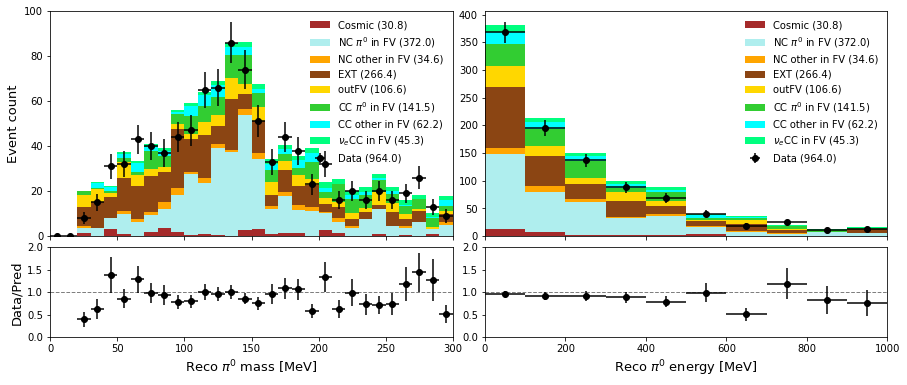

0.9098302803686341


In [19]:
#hist_kineE = [x[x.reco_pi0_energy < 1000].kine_reco_Enu for x in samples]
hist_mass = [x[x.reco_pi0_energy < 1000].kine_pio_mass for x in samples]
hist_pi0energy = [x[x.reco_pi0_energy < 1000].reco_pi0_energy for x in samples]
w_ = [x[x.reco_pi0_energy < 1000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]

two_panel_plot([hist_mass,hist_pi0energy], [w_,w_], [30,10], [(0,300),(0,1000)], [colors,colors], [l_,l_], 
               [r'Reco $\pi^{0}$ mass [MeV]',r'Reco $\pi^{0}$ energy [MeV]'], ['Event count','Event count'])

# Evaluate DATA/Prediction
print(sum(w_[0]) / sum([sum(x) for x in w_[1:]])) 

In [20]:
print('Total efficiency: %1.3f / %1.3f = %1.3f'%(sum(w_[2]), sum(Active(df_NC_pi0_all).weight), sum(w_[2])/sum(Active(df_NC_pi0_all).weight)))

tot = sum([sum(x) for x in w_[1:]]) # Excluding df_data
print('Total purity: %1.3f / %1.3f = %1.3f'%(sum(w_[2]), tot, sum(w_[2])/tot))

Total efficiency: 372.048 / 1835.983 = 0.203
Total purity: 372.048 / 1059.538 = 0.351


In [21]:
colors =   ['black',  'brown',    'paleturquoise',       'orange',          'saddlebrown', 'gold',    'limegreen',            'aqua',           'springgreen']
labels =   ['Data',   'Cosmic',   r'NC $\pi^{0}$ in FV', 'NC other in FV',  'EXT',         'outFV',   r'CC $\pi^{0}$ in FV',  'CC other in FV', r'$\nu_{e}$CC in FV']
families = ['DATA',   'MC',       'MC',                  'MC',              'DATA',        'MC',      'MC',                   'MC',             'MC']
samples =  [df_data,  df_cosmic,  df_NC_pi0,             df_NC_,            df_ext,        df_outFV,  df_CC_pi0,              df_CC_,           df_nue]
samples =  [reco_pi0_energy(is_FC(is_pi0(is_NC(is_generic(x)), family=y))) for x,y in zip(samples,families)]

/home/gs627/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Panel Left: Chi-square = nan, p-value = nan
Panel Left: Chi-square = 15.3481, p-value = 0.0818


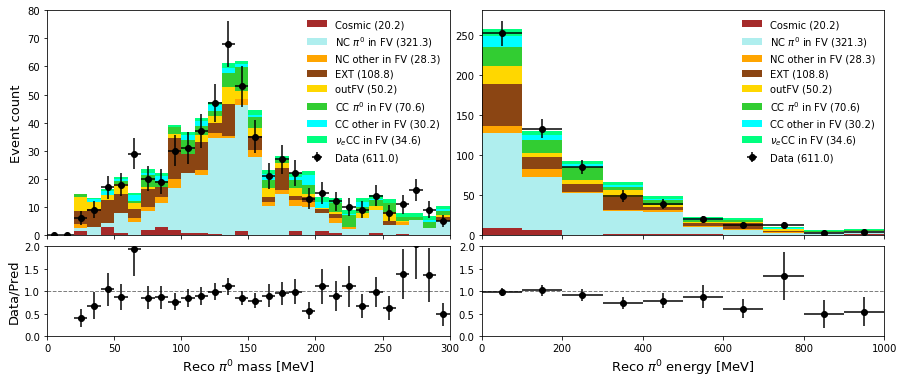

0.920083710362393


In [22]:
#hist_kineE = [x[x.reco_pi0_energy < 1000].kine_reco_Enu for x in samples]
hist_mass = [x[x.reco_pi0_energy < 1000].kine_pio_mass for x in samples]
hist_pi0energy = [x[x.reco_pi0_energy < 1000].reco_pi0_energy for x in samples]
w_ = [x[x.reco_pi0_energy < 1000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]

two_panel_plot([hist_mass,hist_pi0energy], [w_,w_], [30,10], [(0,300),(0,1000)], [colors,colors], [l_,l_], 
               [r'Reco $\pi^{0}$ mass [MeV]',r'Reco $\pi^{0}$ energy [MeV]'], ['Event count','Event count'])

# Evaluate DATA/Prediction
print(sum(w_[0]) / sum([sum(x) for x in w_[1:]])) 

In [23]:
print('Total efficiency (FC): %1.3f / %1.3f = %1.3f'%(sum(w_[2]), sum(Active(df_NC_pi0_all).weight), sum(w_[2])/sum(Active(df_NC_pi0_all).weight)))

tot = sum([sum(x) for x in w_[1:]]) # Excluding df_data
print('Total purity (FC): %1.3f / %1.3f = %1.3f'%(sum(w_[2]), tot, sum(w_[2])/tot))

Total efficiency (FC): 321.251 / 1835.983 = 0.175
Total purity (FC): 321.251 / 664.070 = 0.484


### Import weights new BDT

In [65]:
model = xgb.Booster()
model.load_model("../bnb/nc_training/model_notune_6_28_1131am.txt")

### Assign BDT weights

In [66]:
variables = BDT_variables[:-2] + KINE_variables                  # Variables for training

In [67]:
df_data.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_data[variables]))
df_cosmic.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_cosmic[variables]))
df_NC_pi0.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_NC_pi0[variables]))
df_NC_.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_NC_[variables]))
df_ext.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_ext[variables]))
df_outFV.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_outFV[variables]))
df_CC_pi0.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_CC_pi0[variables]))
df_CC_.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_CC_[variables]))
df_nue.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_nue[variables]))

In [95]:
VALUE = 0.97

def NCpi0(df, bdt_value=VALUE):
    df_ = df[(df.ncpi0_score > bdt_value) & (df.numu_score <= 0.9) & (df.nue_score <= 7)]
    return df_

def not_NCpi0(df, bdt_value=VALUE):
    df_ = df[~((df.ncpi0_score > bdt_value) & (df.numu_score <= 0.9) & (df.nue_score <= 7))]
    return df_

In [96]:
colors =   ['black',  'brown',    'paleturquoise',       'orange',          'saddlebrown', 'gold',    'limegreen',            'aqua',           'springgreen']
labels =   ['Data',   'Cosmic',   r'NC $\pi^{0}$ in FV', 'NC other in FV',  'EXT',         'outFV',   r'CC $\pi^{0}$ in FV',  'CC other in FV', r'$\nu_{e}$CC in FV']
families = ['DATA',   'MC',       'MC',                  'MC',              'DATA',        'MC',      'MC',                   'MC',             'MC']
samples =  [df_data,  df_cosmic,  df_NC_pi0,             df_NC_,            df_ext,        df_outFV,  df_CC_pi0,              df_CC_,           df_nue]
samples =  [reco_pi0_energy(NCpi0(is_generic(x))) for x in samples]

/home/gs627/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Panel Left: Chi-square = nan, p-value = nan
Panel Left: Chi-square = 34.5129, p-value = 0.0001


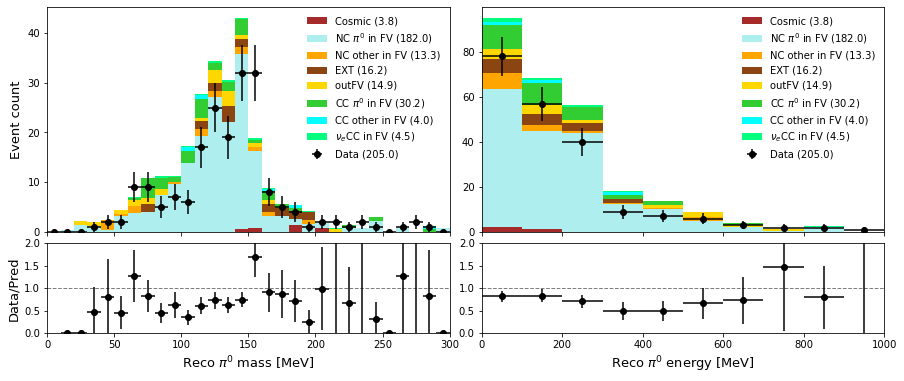

0.7621885077967111


In [97]:
#hist_kineE = [x[x.reco_pi0_energy < 1000].kine_reco_Enu for x in samples]
hist_mass = [x[x.reco_pi0_energy < 1000].kine_pio_mass for x in samples]
hist_pi0energy = [x[x.reco_pi0_energy < 1000].reco_pi0_energy for x in samples]
w_ = [x[x.reco_pi0_energy < 1000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]

two_panel_plot([hist_mass,hist_pi0energy], [w_,w_], [30,10], [(0,300),(0,1000)], [colors,colors], [l_,l_], 
               [r'Reco $\pi^{0}$ mass [MeV]',r'Reco $\pi^{0}$ energy [MeV]'], ['Event count','Event count'])

# Evaluate DATA/Prediction
print(sum(w_[0]) / sum([sum(x) for x in w_[1:]])) 

In [98]:
print('Total efficiency: %1.3f / %1.3f = %1.3f'%(sum(w_[2]), sum(Active(df_NC_pi0_all).weight), sum(w_[2])/sum(Active(df_NC_pi0_all).weight)))

tot = sum([sum(x) for x in w_[1:]]) # Excluding df_data
print('Total purity: %1.3f / %1.3f = %1.3f'%(sum(w_[2]), tot, sum(w_[2])/tot))

Total efficiency: 182.003 / 1835.983 = 0.099
Total purity: 182.003 / 268.962 = 0.677
